Get reference genome of Thalassolituus oleivorans MIL-1 in FASTA and Genbank formats

In [ ]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

### Reading sequences

In [3]:
!pip install bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.6 MB/s eta 0:00:00


In [2]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

for record in SeqIO.parse("/content/GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('/content/GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [3]:
start, end = gb.features[0].location.start, None

ncod = []
cod = []

# write coding and non-coding sequences
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[start:end]) != 0:
      ncod.append(seq[start:end].__str__())

    start = feature.location.end

### Initial probabilities

In [4]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'),
      seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T,
                       index=['T', 'C', 'A', 'G'],
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [5]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181143,0.296068,0.315043,0.273024
C,0.206706,0.227065,0.233173,0.228923
A,0.256916,0.302111,0.238480,0.276478
G,0.355236,0.174755,0.213304,0.221574


### Transition probabilities

In [6]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3],
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1

    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5),
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [7]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185482,0.497862,0.316308,0.318271
C|T,0.189688,0.199483,0.179891,0.208911
A|T,0.249131,0.172440,0.221458,0.243934
G|T,0.375698,0.130215,0.282343,0.228884
T|C,0.185235,0.248571,0.269872,0.252402
C|C,0.156213,0.197930,0.244217,0.214059
A|C,0.276197,0.315174,0.244461,0.286765
G|C,0.382355,0.238325,0.241449,0.246775
T|A,0.179889,0.334011,0.307774,0.270128
C|A,0.194131,0.213909,0.193560,0.205302


TATTACTTC
P(seq NC)=P(T|NC)*Pnc(A|T)*Pnc(T|A)*P(T|T)*P(A|T)...

In [8]:
P_seq_nc = t1['nc']['T'] * t2['nc']['A|T']*t2['nc']['T|A']*t2['nc']['T|T']*t2['nc']['A|T']*t2['nc']['C|A']*t2['nc']['T|C']*t2['nc']['T|T']*t2['nc']['C|T']
P_seq_nc

4.812341505624151e-06

In [9]:
t2['nc']['A|T']

0.24393437391475742

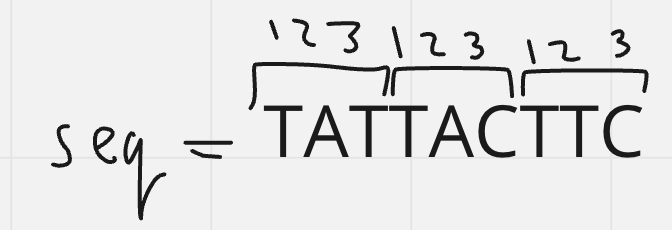

In [10]:
P_seq_cod = t1['pos1']['T']   * t2['pos2']['A|T'] * t2['pos3']['T|A'] * \
            t2['pos1']['T|T'] * t2['pos2']['A|T'] * t2['pos3']['C|A'] * \
            t2['pos1']['T|C'] * t2['pos2']['T|T'] * t2['pos3']['C|T']
P_seq_cod

9.873955022651802e-07

In [11]:
P_nc = 0.5
P_cod = 0.5
P_nc_seq = P_nc * P_seq_nc / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_nc_seq

0.8297516765118772

In [12]:
P_cod_seq = P_cod * P_seq_cod / (P_nc * P_seq_nc + P_cod * P_seq_cod)
P_cod_seq

0.17024832348812277

In [13]:
1-P_nc_seq

0.1702483234881228

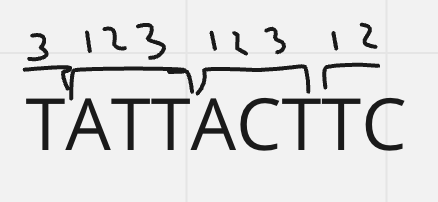

In [14]:
P_seq_cod2 = t1['pos3']['T'] * \
            t2['pos1']['A|T'] * t2['pos2']['T|A'] * t2['pos3']['T|T'] * \
            t2['pos1']['A|T'] * t2['pos2']['C|A'] * t2['pos3']['T|C'] * \
            t2['pos1']['T|T'] * t2['pos2']['C|T']
P_seq_cod2

4.4125895605963545e-06

### Prediction

In [25]:
!pip install orffinder

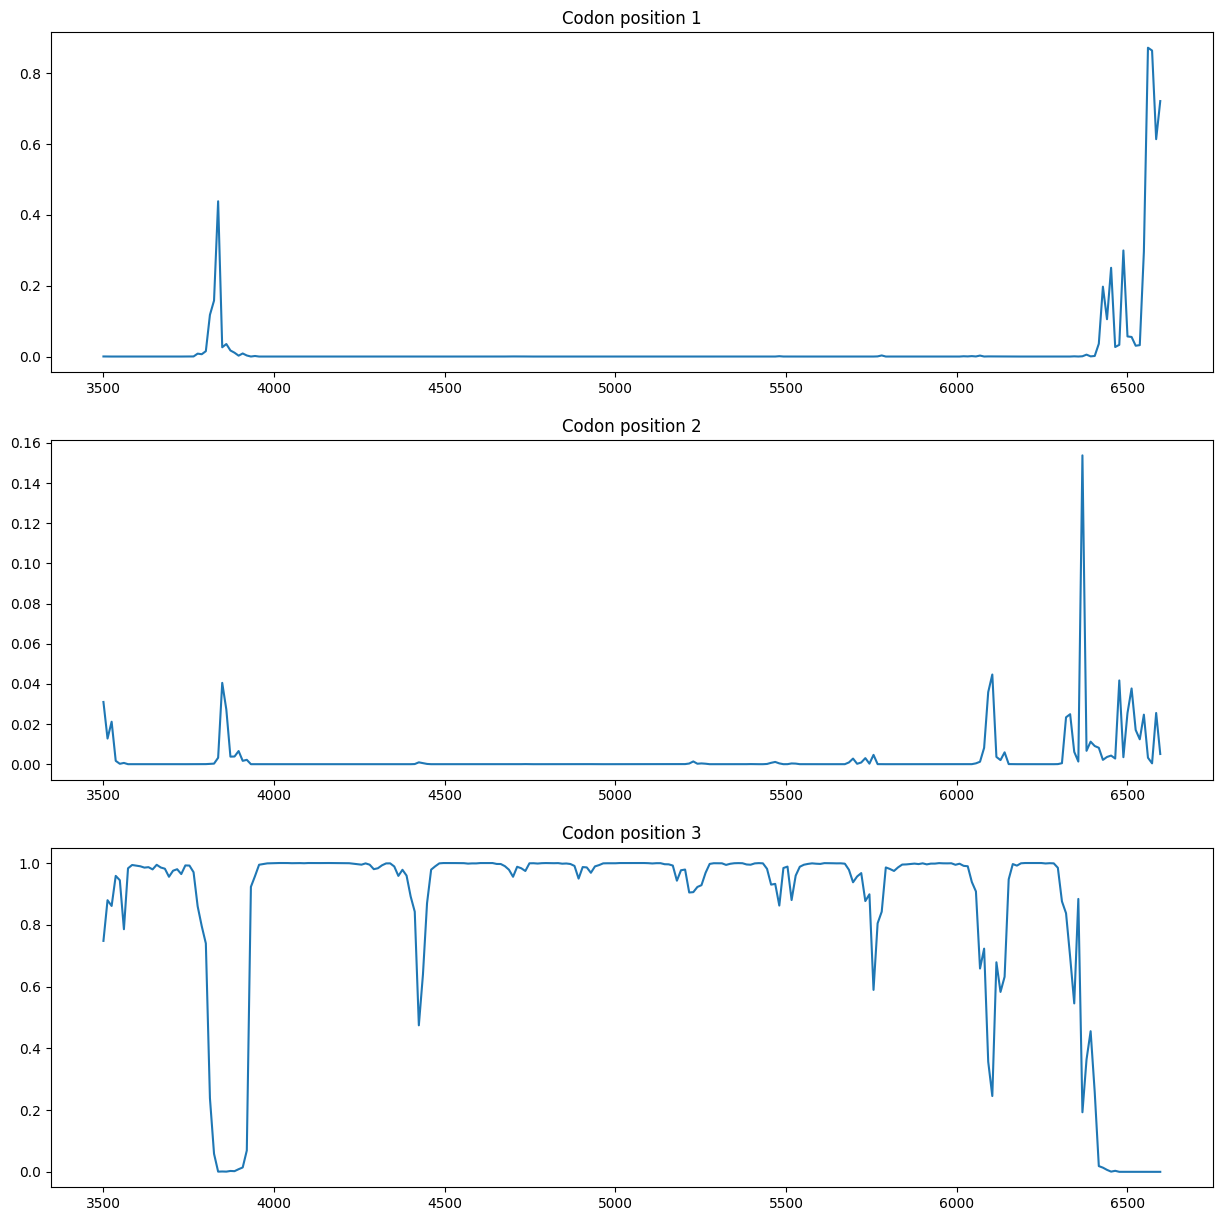

In [26]:
from functools import reduce
from orffinder import orffinder

def ncod_proba(seq, t1, t2):
  if not seq:
    print('No sequence')
    return None
  return np.exp(sum(np.log(t2['nc'][f"{nuc}|{prev_nuc}"]) for prev_nuc, nuc in zip(seq, seq[1:])) + np.log(t1['nc'][seq[0]]))

def cod_proba(seq, t1, t2, frame=1):
    match len(seq):
        case 0:
            print('No sequence')
            return None
    match frame:
        case 1:
            log_prob, prev_pos = np.log(t1['pos1'][seq[0]]), 1
        case 2:
            log_prob, prev_pos = np.log(t1['pos3'][seq[0]]), 3
        case 3:
            log_prob, prev_pos = np.log(t1['pos2'][seq[0]]), 2
        case _:
            print('No such frame')
            return None
    prev_nuc = seq[0]
    for i, nuc in enumerate(seq[1:]):
        pair = f'{nuc}|{prev_nuc}'
        match prev_pos:
            case 1:
                log_prob += np.log(t2['pos2'][pair])
                prev_pos = 2
            case 2:
                log_prob += np.log(t2['pos3'][pair])
                prev_pos = 3
            case 3:
                log_prob += np.log(t2['pos1'][pair])
                prev_pos = 1
        prev_nuc = nuc
    return np.exp(log_prob)

def get_cod_probs(seq, t1, t2):
    probs = [cod_proba(seq, t1, t2, frame=i) for i in range(1, 4)] + [ncod_proba(seq, t1, t2)]
    total_prob = reduce(lambda x, y: x + y, probs)
    return [prob / total_prob for prob in probs]

def plot_graph(data, start, end, step):
  fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
  x = range(start, end, step)
  ax1.plot(x, data[:, 0])
  ax1.set_title('Codon position 1')
  ax2.plot(x, data[:, 1])
  ax2.set_title('Codon position 2')
  ax3.plot(x, data[:, 2])
  ax3.set_title('Codon position 3')
  plt.show()


# DNA segment from .gbff file with genes only on positive strand
start = 3500
end = 6600
step = 12
window = 96
pos_probs = []
for i in range(start, end, step):
  pos_probs.append(get_cod_probs(seq[i:i+window], t1, t2))
pos_probs = np.array(pos_probs)

plot_graph(pos_probs, start, end, step)